In [1]:
import requests
import logging
from datetime import datetime
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import AutoRegResults
import math
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

# Part 0. Constants and assumptions

In [2]:
# general BC params
SLOTS_PER_EPOCH = 32
SECONDS_PER_SLOT = 12
MIN_PER_EPOCH_CHURN_LIMIT = 2**2
CHURN_LIMIT_QUOTIENT = 2**16 # (=65,536)
MIN_GENESIS_TIME = 1606824000 # (Dec 1, 2020, 12pm UTC)
EPOCHS_PER_YEAR = 82180
SECONDS_PER_YEAR = 31556952
# genesis
GENESIS_DATE = '2020-12-01'
GENESIS_VALIDATORSCOUNT = 21063
# altair fork Oct-27-2021 10:56:23 AM +UTC Epoch number: 74,240
ALTAIR_EPOCH = 74240
altair_validatorscount = requests.get(f"https://beaconcha.in/api/v1/epoch/{ALTAIR_EPOCH}", headers={"accept":"application/json"}).json()['data']['validatorscount']
altair_multiplier = 0.989
# Merge date
MERGE_DATE = '2022-06-01'
# Lido fee
lido_fee = 0.1
# Priority fee
priority_fee_monthly  = 22275.39743667664 # https://dune.xyz/queries/382535 (query date: 2022-04-06 11:00 UTC)
# MEV (Flashbots data)
avg_mev_reward_per_block = 0.185 # inferring from flashbots activity, we obtain this number by substracting the Flashbots miner tip from the tail gas price multiplied by the gas used by the mined Flashbots bundle.
lower_bound_for_active_staked_eth = 524288 # required for ETH2 to start
block_selection_frequency_flashbots = 58 # % of blocks seen by Flashbots-enabled miners contains Flashbots bundles


In [3]:
def get_epoch_data(epoch="latest"):
    try:
        req = requests.get(f"https://beaconcha.in/api/v1/epoch/{epoch}", headers={"accept":"application/json"})
        req.raise_for_status()
        return req.json()["data"]
    except requests.exceptions.HTTPError as err:
        logging.error(err)
        return {}

def get_latest_epoch():
    return get_epoch_data()['epoch']

def get_epochs(start_epoch, end_epoch, epoch_interval):
    epochs_list = []
    max_iteration = 19
    iteration = 0
    current_stat_epoch = start_epoch
    current_end_epoch = min(start_epoch + max_iteration*epoch_interval, end_epoch)
    while current_end_epoch < end_epoch or current_stat_epoch < end_epoch:
        if current_end_epoch < end_epoch:
            epochs_list.append([x for x in range(current_stat_epoch, current_end_epoch, int(epoch_interval))])
        else: 
            epochs_list.append([x for x in range(current_stat_epoch, end_epoch, int(epoch_interval))])
        iteration += 1
        current_stat_epoch = (start_epoch + iteration*max_iteration*epoch_interval)        
        current_end_epoch = (current_stat_epoch + max_iteration*epoch_interval)
        
    return epochs_list

def get_validatorscount(epochs):  
    return [get_epoch_data(x)['validatorscount'] for x in epochs]

def get_df(start_epoch, end_epoch, epoch_interval):
    epochs_list = get_epochs(start_epoch, end_epoch, epoch_interval)
    validatorscountdyn=[]
    epochs = []
    for iter in epochs_list:
        validatorscountdyn += get_validatorscount(iter)
        epochs += iter
        if  iter != epochs_list[-1]: time.sleep(60)
    return pd.DataFrame({'epoch': epochs, 'validatorscount': validatorscountdyn}).set_index('epoch')

def get_df_validatorscount(file_name, epoch_interval, start_epoch, is_dataset_new):
    end_epoch = get_latest_epoch()
    if is_dataset_new: 
        df = get_df(start_epoch, end_epoch, epoch_interval)
    else: 
        df = pd.read_csv(file_name, sep = ",", index_col=['epoch'])
        start_epoch_ = max(df.index)+epoch_interval
        df = pd.concat([df, get_df(start_epoch_, end_epoch, epoch_interval)])
    df.to_csv(file_name, sep=',', encoding='utf-8', index=True)

def annualised_base_reward(validatorscount):
    return EPOCHS_PER_YEAR * 512 / math.sqrt(validatorscount * 32e9) # assuming all validators have an effective balance of 32 ETH

def average_blocks_proposed_per_year(validatorscount): 
    return SECONDS_PER_YEAR / (SECONDS_PER_SLOT * validatorscount) 

# Patr 1. Modeling with and without MEV (Flashbots' data)

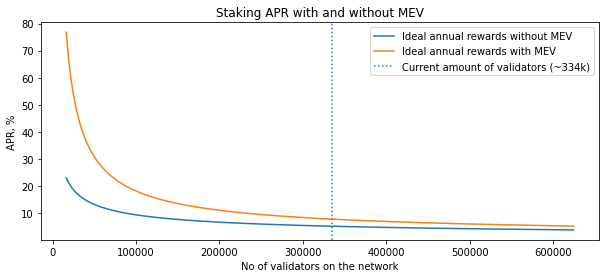

In [4]:
# Ideal, with and without MEV
validators_on_the_network_today = get_epoch_data(epoch="latest")['validatorscount']
upper_bound_for_active_staked_eth = 2*10e6 # 10M
max_number_of_validators_vbuterin = 524288 #https://ethresear.ch/t/simplified-active-validator-cap-and-rotation-proposal/9022
n_validators = [n for n in range(lower_bound_for_active_staked_eth//32,int(upper_bound_for_active_staked_eth)//32,1000)] # get no of validators for the range 0.5M to 10M staked ETH, 3200 at a time
ideal_reward = [(4 * annualised_base_reward(n)) for n in n_validators]
ideal_reward_with_mev = [(4 * annualised_base_reward(n) +  (avg_mev_reward_per_block * average_blocks_proposed_per_year(n) * (block_selection_frequency_flashbots/100)) ) for n in n_validators]

fig, ax = plt.subplots(figsize=(10, 4))

ax.plot([n for n in n_validators], [100 * r / 32 for r in ideal_reward], label='Ideal annual rewards without MEV')
ax.plot([n for n in n_validators], [100 * r / 32 for r in ideal_reward_with_mev], label='Ideal annual rewards with MEV')
plt.axvline(x=validators_on_the_network_today, linestyle="dotted", label=f"Current amount of validators (~{validators_on_the_network_today//1000}k)")
#plt.axvline(x=max_number_of_validators_vbuterin, color = 'red', linestyle="dotted", label="Maximum number of validators that be “awake” (524k)")
ax.set_xlabel('No of validators on the network')
ax.set_ylabel('APR, %')
ax.set_title('Staking APR with and without MEV')
leg = ax.legend()

# Part 2. Preparing dataset of validatorscount

In [5]:
start_epoch = 65812 #2021-09-19
epoch_per_day = int(24*3600/(SLOTS_PER_EPOCH * SECONDS_PER_SLOT))
file_name = 'validatorscount.csv'
get_df_validatorscount(file_name, epoch_per_day, start_epoch, False)

In [6]:
# df_validatorscount - dataset for modeling (since 2021-09-19 till now)
df_validatorscount_for_forecast = pd.read_csv('validatorscount.csv', sep = ",", index_col=['epoch'])
df_validatorscount_for_forecast['date'] = [datetime.utcfromtimestamp(MIN_GENESIS_TIME+x*SLOTS_PER_EPOCH * SECONDS_PER_SLOT).strftime('%Y-%m-%d') for x in df_validatorscount_for_forecast.index]
df_validatorscount_for_forecast.to_csv(f'df_validatorscount.csv', sep=',', encoding='utf-8', index=True)
df_validatorscount_for_forecast = pd.read_csv('df_validatorscount.csv', sep = ",",index_col=['date'], parse_dates=['date'])[['epoch', 'validatorscount']]
print(f"Period that is taken for modeling: {df_validatorscount_for_forecast.index[0]} - {df_validatorscount_for_forecast.index[-1]}")

Period that is taken for modeling: 2021-09-19 00:00:00 - 2022-04-05 00:00:00


In [7]:
# df_validatorscountall - dataset from the begining of BC till now
df_validatorscount_actual = pd.concat([pd.read_csv('df_validatorscount_p1.csv', sep = ",",index_col=['date'], parse_dates=['date'])[['epoch', 'validatorscount']], df_validatorscount_for_forecast])
validatorscount_prealtair = df_validatorscount_actual.query('epoch<@ALTAIR_EPOCH').validatorscount.values
validatorscount_altair_actual = df_validatorscount_actual.query('epoch>=@ALTAIR_EPOCH').validatorscount.values

Entry queue in March 2022 is due to launching 2022-02-23 Aave<>Lido


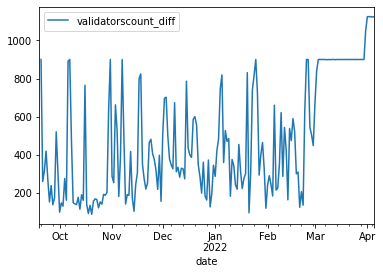

In [8]:
df_validatorscount_for_forecast['validatorscount_diff'] = df_validatorscount_for_forecast['validatorscount'].diff()
df_validatorscount_for_forecast[['validatorscount_diff']].plot()
print("Entry queue in March 2022 is due to launching 2022-02-23 Aave<>Lido")

In [9]:
df_validatorscount_for_forecast_1 = df_validatorscount_for_forecast[df_validatorscount_for_forecast.index<pd.Timestamp('2022-02-23')][['epoch', 'validatorscount']]
df_validatorscount_for_forecast_2 = df_validatorscount_for_forecast[df_validatorscount_for_forecast.index>=pd.Timestamp('2022-02-23')][['epoch', 'validatorscount']]

# Part 3. Modeling validatorscount growth before Merge

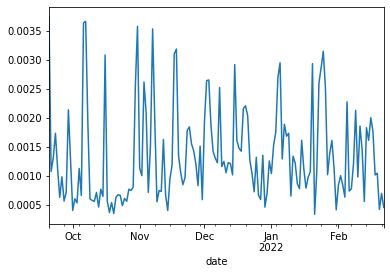

In [10]:
dataset = df_validatorscount_for_forecast_1.copy()
dataset['validatorscount_diff'] = dataset.validatorscount.rolling(2).apply(lambda x: x[-1]/x[0]-1, raw=True)
series = dataset.validatorscount_diff[1:]
series.plot()
plt.show()

AR model coef: [-1.02581215e-05 -3.78306878e-01 -5.28497458e-01 -3.82281507e-01
 -2.89589415e-01 -2.34667850e-01 -2.00050114e-01]

Test RMSE: 0.00077


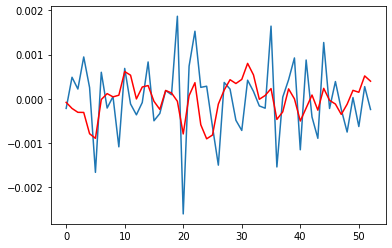

In [11]:
# fit and evaluate an AR model

def difference(dataset):
	diff = []
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return np.array(diff)


def predict(coef, history):
	yhat = coef[0]
	for i in range(1, len(coef)):
		yhat += coef[i] * history[-i]
	return yhat


# split dataset
X = difference(series.values)
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:]
# train autoregression
window = 6
model = AutoReg(train, lags=6)
model_fit = model.fit()
coef = model_fit.params
print("AR model coef:",coef)
print()
# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
	yhat = predict(coef, history)
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
rmse = math.sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.5f' % rmse)

plt.plot(test)
plt.plot(predictions, color='red')
plt.show()

In [12]:
# fit an AR model and save the whole model to file

def AR_model(series):

    def difference(dataset):
        diff = []
        for i in range(1, len(dataset)):
            value = dataset[i] - dataset[i - 1]
            diff.append(value)
        return np.array(diff)


    X = difference(series.values)
    # fit model
    model = AutoReg(X, lags=6)
    model_fit = model.fit()
    coef = model_fit.params
   # print("AR model coef:",coef)

    # save the model, the differenced dataset and the last ob to the files
    model_fit.save('ar_model.pkl')
    np.save('ar_data.npy', X)
    np.save('ar_obs.npy', [series.values[-1]])

In [13]:
def add_observation(observation):
    
    # load the saved data
    model = AutoRegResults.load('ar_model.pkl')
    data = np.load('ar_data.npy')
    last_ob = np.load('ar_obs.npy')
    # update and save differenced observation
    diffed = observation - last_ob[0]
    data = np.append(data, [diffed], axis=0)
    model = AutoReg(data, lags=6)
    model_fit = model.fit()
    model_fit.save('ar_model.pkl')
    np.save('ar_data.npy', data)
    # update and save real observation
    last_ob[0] = observation
    np.save('ar_obs.npy', last_ob)

    
def add_observation_model_const(observation):
    
    # load the saved data
    model = AutoRegResults.load('ar_model.pkl')
    data = np.load('ar_data.npy')
    last_ob = np.load('ar_obs.npy')
    diffed = observation - last_ob[0]
    data = np.append(data, [diffed], axis=0)
    np.save('ar_data.npy', data)
    # update and save real observation
    last_ob[0] = observation
    np.save('ar_obs.npy', last_ob)


def get_forecast():
    
    # load model
    model = AutoRegResults.load('ar_model.pkl')
    data = np.load('ar_data.npy')
    last_ob = np.load('ar_obs.npy')

    # make prediction
    predictions = model.predict(start=len(data), end=len(data))
    # transform prediction
    yhat = predictions[0] + last_ob[0]
    return yhat


def forecast_diff(last_ob, last_date, forcast_period, model_update,columns):
    forcast_date = last_date + pd.to_timedelta(str(forcast_period) + ' day')
    forcast_dir = {}
    
    while last_ob>0 and last_date<forcast_date:
        
        if model_update: add_observation(last_ob)
        else: add_observation_model_const(last_ob)
            
        last_ob = get_forecast()
        last_date +=pd.to_timedelta('1 day')
        forcast_dir.update({last_date:last_ob})
        #print(last_date,last_ob)
        
    return pd.DataFrame(pd.Series(forcast_dir), columns = columns)


def forecast_validatorscount(last_validatorscount, last_date, df_forecast_diff,columns):
    
    validatorscount_dic = {}
        
    for i in df_forecast_diff:
        last_validatorscount = (i+1)*last_validatorscount
        last_date += pd.to_timedelta('1 day')
        validatorscount_dic.update({last_date:int(last_validatorscount)})
        
    return pd.DataFrame(pd.Series(validatorscount_dic), columns = columns)

def final_forecast(df_forecast_validatorscount, df):
    
    df_forecasted = pd.concat([df, df_forecast_validatorscount])
    display(df_forecasted.tail())
    
    fig, ax = plt.subplots(figsize=(20, 8))

   # ax.plot(df_forecasted.index.values, df_forecasted.validatorscount.values)
    ax.plot(df.index.values, df.validatorscount.values, label="No of validators")
    ax.plot(df_forecast_validatorscount.index.values, df_forecast_validatorscount.validatorscount.values, linestyle="dotted", label="No of validators forecasted")
    ax.set_xlabel('Date')
    ax.set_ylabel('No of validators on the network')
    ax.set_title('Validators (forecast before Merge)')
    ax.legend()
    plt.show()
    
    return df_forecasted

In [14]:
# forecast period
forcast_period = (pd.Timestamp(MERGE_DATE) - series.index[-1]).days-1
last_ob = series.values[-1]
last_date = series.index[-1]
last_epoch = dataset.epoch[-1]
last_validatorscount = dataset.validatorscount[-1]
model_update = True
columns_diff = ['validatorscount_diff']
columns_validatorscount = ['validatorscount']


AR_model(series)
#forecast differences
df_forecast_diff = forecast_diff(last_ob, last_date, forcast_period, model_update, columns_diff)
#forecast validatorscounts
df_validatorscount_altair_forecast_AR = forecast_validatorscount(last_validatorscount, last_date, df_forecast_diff.validatorscount_diff, columns_validatorscount)
df_validatorscount_altair_forecast_AR['epoch'] = [x for x in range(last_epoch+epoch_per_day,last_epoch+epoch_per_day*(forcast_period+1), epoch_per_day)]

#validatorscount_altair_forecast_AR = df_validatorscount_altair_forecast_AR.validatorscount.values
#validatorscount_altair_AR = np.concatenate([validatorscount_altair_actual, validatorscount_altair_forecast_AR])

#df_validatorscount_before_merge_AR = final_forecast(df_validatorscount_altair_forecast_AR, df_validatorscount_actual[df_validatorscount_actual.index<pd.Timestamp('2022-02-23')])

In [15]:
# Validators per epoch forecasted
validators_per_epoch_forecasted = (df_validatorscount_altair_forecast_AR.validatorscount[-1]-df_validatorscount_altair_forecast_AR.validatorscount[1])/(df_validatorscount_altair_forecast_AR.epoch[-1]-df_validatorscount_altair_forecast_AR.epoch[1])
print(f'Validators per epoch forecasted (autoregression): {validators_per_epoch_forecasted:0.2f}')

Validators per epoch forecasted (autoregression): 0.60


In [16]:
current_entry_queue = requests.get(f'https://beaconcha.in/api/v1/validators/queue', headers={"accept":"application/json"}).json()['data']['beaconchain_entering']
current_entry_queue

14199

In [17]:
for x in range (int(current_entry_queue/validators_on_the_network_today*CHURN_LIMIT_QUOTIENT*1.5/epoch_per_day)):
    df_validatorscount_for_forecast_2.loc[df_validatorscount_for_forecast_2.index[-1] + pd.to_timedelta('1 day')] = [df_validatorscount_for_forecast_2.epoch[-1]+epoch_per_day, df_validatorscount_for_forecast_2.validatorscount[-1]+int(df_validatorscount_for_forecast_2.validatorscount[-1]/CHURN_LIMIT_QUOTIENT*epoch_per_day)]

,epoch,validatorscount
2022-05-27,122062,358921.0
2022-05-28,122287,359006.0
2022-05-29,122512,359090.0
2022-05-30,122737,359173.0
2022-05-31,122962,359255.0


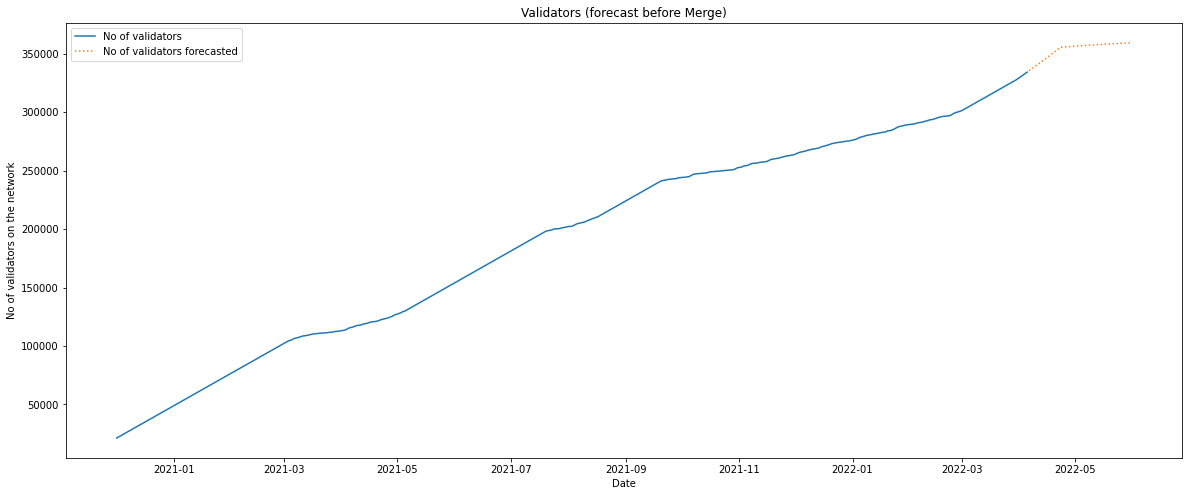

In [18]:
validatorscount_delta = df_validatorscount_for_forecast_2.validatorscount[-1] - df_validatorscount_altair_forecast_AR.at[pd.Timestamp(df_validatorscount_for_forecast_2.index[-1]), 'validatorscount']

df_validatorscount_altair_forecast_AR.validatorscount = np.concatenate([
    df_validatorscount_for_forecast_2.validatorscount.values,
    df_validatorscount_altair_forecast_AR[df_validatorscount_altair_forecast_AR.index > df_validatorscount_for_forecast_2.index[-1]].validatorscount.values + validatorscount_delta
])
df_validatorscount_altair_forecast_AR = df_validatorscount_altair_forecast_AR[df_validatorscount_altair_forecast_AR.index>df_validatorscount_actual.index[-1]]
validatorscount_altair_forecast_AR = df_validatorscount_altair_forecast_AR.validatorscount.values
df_validatorscount_before_merge_AR = final_forecast(df_validatorscount_altair_forecast_AR, df_validatorscount_actual)
validatorscount_altair_AR = df_validatorscount_before_merge_AR.query('epoch>=@ALTAIR_EPOCH').validatorscount.values

## Linear forecasting

In [19]:
# Validators per epoch linear
validators_per_epoch = (df_validatorscount_for_forecast_1.validatorscount[-1]-df_validatorscount_for_forecast_1.validatorscount[1])/(df_validatorscount_for_forecast_1.epoch[-1]-df_validatorscount_for_forecast_1.epoch[1])
print(f'Validators per epoch forecasted (linear modelling): {validators_per_epoch:0.2f}')

Validators per epoch forecasted (linear modelling): 1.60


In [20]:
# Validatorscount tha day before Merge (linear modelling)
validatorscount_linear = int(df_validatorscount_for_forecast_2.validatorscount[-1]) + int(validators_per_epoch*epoch_per_day)*((pd.Timestamp(MERGE_DATE) - df_validatorscount_for_forecast_2.index[-1]).days-1)
validatorscount_linear

368968

,epoch,validatorscount
2022-05-27,122062,367532.0
2022-05-28,122287,367891.0
2022-05-29,122512,368250.0
2022-05-30,122737,368609.0
2022-05-31,122962,368968.0


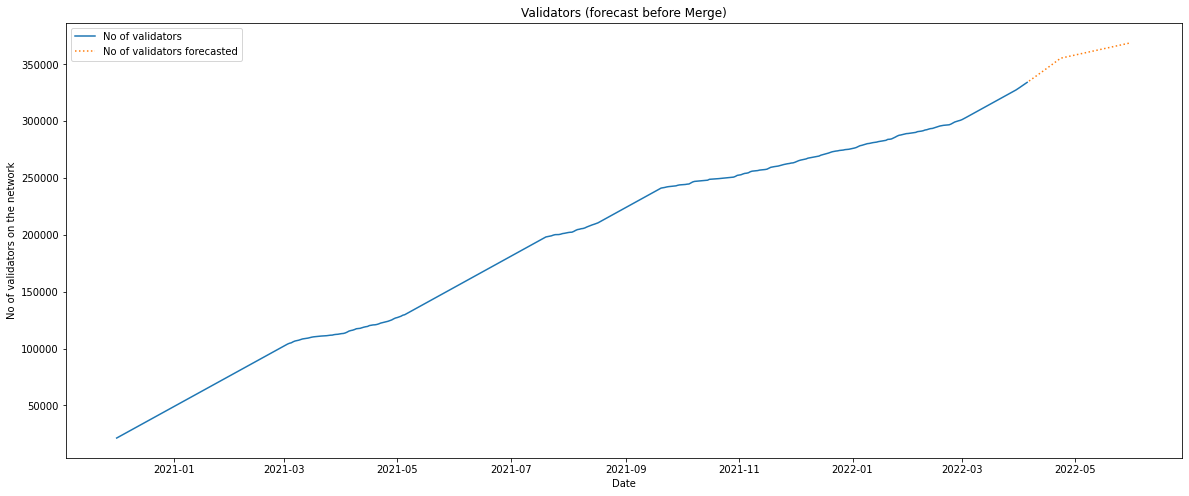

In [21]:
validatorscount_altair_forecast_linear = np.concatenate(
    [df_validatorscount_for_forecast_2[df_validatorscount_for_forecast_2.index>df_validatorscount_actual.index[-1]].validatorscount.values,
    [x for x in range(
    int(df_validatorscount_for_forecast_2.validatorscount[-1])+int(validators_per_epoch*epoch_per_day), 
    int(df_validatorscount_for_forecast_2.validatorscount[-1]) + int(validators_per_epoch*epoch_per_day)*((pd.Timestamp(MERGE_DATE) - df_validatorscount_for_forecast_2.index[-1]).days-1)+1, 
    int(validators_per_epoch*epoch_per_day)
    )]
    ])
df_validatorscount_altair_forecast_linear = df_validatorscount_altair_forecast_AR.copy()
df_validatorscount_altair_forecast_linear.validatorscount = validatorscount_altair_forecast_linear
df_validatorscount_before_merge_linear = final_forecast(df_validatorscount_altair_forecast_linear, df_validatorscount_actual)
validatorscount_altair_linear = df_validatorscount_before_merge_linear.query('epoch>=@ALTAIR_EPOCH').validatorscount.values

# Part 4. Modeling queue after Merge

## Choosing the forecast model

There are 2 models:

- autoregression

- linear


In [22]:
is_autoregression_forecast_model = True

In [23]:
is_linear_model = 1-is_autoregression_forecast_model
if is_autoregression_forecast_model == True: 
    df_validatorscount_altair_forecast = df_validatorscount_altair_forecast_AR.copy()
    df_validatorscount_before_merge = df_validatorscount_before_merge_AR.copy()
    validatorscount_altair = validatorscount_altair_AR.copy()
else: 
    df_validatorscount_altair_forecast = df_validatorscount_altair_forecast_linear.copy()
    df_validatorscount_before_merge = df_validatorscount_before_merge_linear.copy()
    validatorscount_altair = validatorscount_altair_linear.copy()


## Functions for preparing datasets, simulation and getting charts

In [24]:
def get_df_bc_lido_actual():

    df = pd.read_csv('eth2_deposits.csv', sep = ",",index_col=['date'], parse_dates=['date'])#[:df_validatorscount_altair_forecast.index[0]-pd.Timedelta('1 day')]
    df['deposits'] = df.eth_amount//32
    df['lido_deposits'] = df.lido_amount//32
    df['eth_amount_cumsum'] = df.eth_amount.cumsum()
    df['lido_amount_cumsum'] = df.lido_amount.cumsum()
    df['lido_share_daily'] = df.lido_amount/df.eth_amount
    df['lido_share'] = df.lido_amount_cumsum/df.eth_amount_cumsum
    df = pd.merge(df, df_validatorscount_before_merge, left_index=True, right_index=True, how='left').fillna(0)
    df['eth_staked'] = df.validatorscount*32
    df['lido_staked'] = df['eth_staked']*df.lido_share

    return df[['validatorscount', 'eth_staked', 'eth_amount', 'lido_share_daily', 'lido_amount', 'lido_staked', 'lido_share']]
    

def get_df_bc_lido_forecasted(df_bc_lido_actual, last_validatorscount, last_lido_staked, eth_amount_before_merge_date, eth_amount_after_merge_date, lido_amount_share_forecast, new_validators_per_epoch, k, period, APR_periods):

    df = df_validatorscount_altair_forecast[['validatorscount']].head(-len(eth_amount_before_merge_date)).copy()
    df['eth_staked'] = df.validatorscount*32
    df['eth_amount'] = (df.validatorscount*32-df.validatorscount.shift(1)*32).fillna(df.validatorscount*32 - last_validatorscount*32)
    
    entry_queue_eth = 0
    for x in np.concatenate((eth_amount_before_merge_date, eth_amount_after_merge_date)):
        entry_queue_eth += x
        new_validators = min(entry_queue_eth//32, epoch_per_day * (df.validatorscount[-1]//CHURN_LIMIT_QUOTIENT))
        validatorscount = df.validatorscount[-1] + new_validators
        df.loc[df.index[-1] + pd.to_timedelta('1 day')] = [validatorscount, validatorscount*32, x]
        entry_queue_eth -=entry_queue_eth
    
    for x in range(365+period - len(eth_amount_after_merge_date)+1):
        validatorscount = df.validatorscount[-1] + epoch_per_day * max(min(new_validators_per_epoch,df.validatorscount[-1]//CHURN_LIMIT_QUOTIENT),k*df.validatorscount[-1]//CHURN_LIMIT_QUOTIENT)
        df.loc[df.index[-1] + pd.to_timedelta('1 day')] = [validatorscount, validatorscount*32, validatorscount*32-df.validatorscount[-1]*32]
        
    df['lido_share_daily'] = lido_amount_share_forecast + lido_amount_share_forecast[-1:]*365
    df['lido_amount'] = df.eth_amount*df.lido_share_daily
    df['lido_staked'] = ((df.eth_staked-df.eth_staked.shift(1))*df.lido_share_daily).fillna(df.lido_amount).cumsum() + last_lido_staked
    df['lido_share'] = df.lido_staked/df.eth_staked

    df = pd.concat([df_bc_lido_actual,df])
  
    ideal_reward = np.concatenate([
    [0]*(pd.Timestamp(GENESIS_DATE) - df.index[0]).days,
    [(4 * annualised_base_reward(n)) for n in validatorscount_prealtair],
    [(4 * annualised_base_reward(n)*altair_multiplier) for n in validatorscount_altair],
    [(4 * annualised_base_reward(n)*altair_multiplier +  (avg_mev_reward_per_block * average_blocks_proposed_per_year(n)  * (block_selection_frequency_flashbots/100))+priority_fee_monthly*12/n) for n in df.loc[pd.Timestamp(MERGE_DATE):].validatorscount.values]
    ])
    

    df['APR'] = [100 * r / 32 for r in ideal_reward]   # Validators' APR

    df['new_validators']=(df.validatorscount - df.validatorscount.shift(1)).fillna(df.validatorscount)

    df['daily_limit'] = (
        (df.validatorscount//CHURN_LIMIT_QUOTIENT)
        .where(df.validatorscount//CHURN_LIMIT_QUOTIENT > MIN_PER_EPOCH_CHURN_LIMIT, MIN_PER_EPOCH_CHURN_LIMIT)*epoch_per_day).where(df.index>pd.Timestamp(GENESIS_DATE),0)
    df.at[pd.Timestamp(GENESIS_DATE), 'daily_limit'] = df.at[pd.Timestamp(GENESIS_DATE),'new_validators']

    entry_queue = [0]
    for i in range(len(df)):
        if entry_queue[-1] + (df.eth_amount[i]//32 - df.daily_limit[i])*32 > 0:
            entry_queue.append(entry_queue[-1] + (df.eth_amount[i]//32 - df.daily_limit[i])*32)
        else: entry_queue.append(0)

    df['entry_queue'] = entry_queue[1:]
    df['lido_entry_queue'] = df.entry_queue*df.lido_share_daily


    df['entry_queue_days'] = (
        (pd.Timestamp(GENESIS_DATE) - df.index).days 
        + (df.entry_queue/32//GENESIS_VALIDATORSCOUNT)*((df.entry_queue//32-GENESIS_VALIDATORSCOUNT)//900+1)).where(
            df.index<pd.Timestamp(GENESIS_DATE), (df.entry_queue/32//df.daily_limit.shift(-1).fillna(df.daily_limit))
        ).astype(int)

    # moment APR for Lido stakers (Validators' APR - Lido's fee)
    df['APR_lido_pool'] = df.APR*df.lido_staked/(df.lido_staked + df.lido_entry_queue)*(1-lido_fee) # staked + entry queue
    df['APR_lido_staked'] = df.APR*(1-lido_fee)
    df['APR_lido_entry_queue'] = [df.loc[df.index[i+x], 'APR']*(1-lido_fee) if i+x < len(df) else df.loc[df.index[-1], 'APR']*(1-lido_fee) for i, x in enumerate(df.entry_queue_days)]

    # actual APR
    for period in APR_periods:
        # Validators' APR
        df[f'APR_actual_entry_queue_{period}'] = ([df.APR[i + min(queue_days, period): period + i].sum()/period for i, queue_days in enumerate([day for day in df.entry_queue_days])])
        df[f'APR_actual_staked_{period}'] = ([df.APR[i : period + i].sum()/period for i, queue_days in enumerate([day for day in df.entry_queue_days])])

        # APR for Lido stakers (Validators' APR - Lido's fee)
        df[f'APR_actual_lido_staked_{period}'] = df[f'APR_actual_staked_{period}']*(1-lido_fee)
        df[f'APR_actual_lido_entry_queue_{period}'] = df[f'APR_actual_entry_queue_{period}']*(1-lido_fee)
        df[f'APR_actual_lido_pool_{period}'] = ((df.lido_staked*df[f'APR_actual_lido_staked_{period}'] + df.lido_entry_queue*df[f'APR_actual_lido_entry_queue_{period}'])/(df.lido_staked + df.lido_entry_queue)).where(df.lido_staked>0,0)
        

        # APR loss for stakers and extra APR for entry queue
        df[f'APR_lido_staked_loss_{period}'] = df[f'APR_actual_lido_staked_{period}'] - df[f'APR_actual_lido_pool_{period}']
        df[f'APR_lido_staked_loss_{period}_%'] = df[f'APR_lido_staked_loss_{period}']/df[f'APR_actual_lido_staked_{period}']*100
        df[f'APR_lido_entry_queue_extra_{period}'] = df[f'APR_actual_lido_pool_{period}'] - df[f'APR_actual_lido_entry_queue_{period}']

        #rewards 
        df[f'rewards_lido_pool_per_1k_{period}'] = df[f'APR_actual_lido_pool_{period}']*period/365/100*1000
        df[f'rewards_lido_staked_per_1k_{period}'] = df[f'APR_actual_lido_staked_{period}']*period/365/100*1000
        df[f'rewards_lido_entry_queue_per_1k_{period}'] = df[f'APR_actual_lido_entry_queue_{period}']*period/365/100*1000

        # loss and extra rewards 
        df[f'rewards_lido_staked_per_1k_loss_{period}'] = df[f'rewards_lido_staked_per_1k_{period}'] - df[f'rewards_lido_pool_per_1k_{period}']
        df[f'rewards_lido_staked_loss_{period}'] = df[f'rewards_lido_staked_per_1k_loss_{period}'] * df.lido_staked/1000
        df[f'rewards_lido_entry_queue_per_1k_extra_{period}'] = df[f'rewards_lido_pool_per_1k_{period}'] - df[f'rewards_lido_entry_queue_per_1k_{period}']
        df[f'rewards_lido_entry_queue_extra_{period}'] = df[f'rewards_lido_entry_queue_per_1k_extra_{period}'] * df.lido_entry_queue/1000

    return df.head(-365)


def general_overview_chart(df, name):

    fig, ax = plt.subplots(3, figsize=(14, 9))#, sharex=True)
    fig.suptitle(f'{name}')

    color = 'tab:blue'
    ax[0].bar(df.index.values, df.eth_amount.values, label='Daily ETH amount')
    ax[0].set_ylabel('ETH amount',color=color)
    ax[0].tick_params(axis='y', labelcolor=color)
    ax[0].set_title(f"General overview")
    ax[0].set_xticks([])

    ax0 = ax[0].twinx() 
    ax0.set_ylabel('Entry queue, days')
    ax0.plot(df.index.values, df.entry_queue_days.values, label='Entry queue, days', color = 'black')
    ax0.set_xticks([])

    lines, labels = ax[0].get_legend_handles_labels()
    lines2, labels2 = ax0.get_legend_handles_labels()
    ax0.legend(lines + lines2, labels + labels2, loc=0)

    df1 = df[df.index>pd.Timestamp(GENESIS_DATE)]

    color = 'tab:red'
    ax[1].set_ylabel('ETH staked', color=color)  
    ax[1].tick_params(axis='y', labelcolor=color)
    ax[1].plot(df1.index.values, df1.eth_staked.values, label='Total ETH staked', color = 'red')
    ax[1].plot(df1.index.values, df1.lido_staked.values, label='Lido ETH staked', color = 'red',linestyle = ":")
    ax[1].set_xticks([])

    ax1 = ax[1].twinx() 
    color = 'tab:green'
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.set_ylabel("Validators' APR, %", color=color)
    ax1.plot(df1.index.values, df1.APR.values, label='APR', color = 'green')
    ax1.set_xticks([])

    lines, labels = ax[1].get_legend_handles_labels()
    lines2, labels2 = ax1.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc='right')

    color = 'tab:blue'
    ax[2].tick_params(axis='y', labelcolor=color)
    ax[2].set_ylabel('No of validators', color=color)
    ax[2].plot(df1.index.values, df1.validatorscount.values, label='New validators daily limit')

    ax2 = ax[2].twinx()
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylabel('Daily limit, validators', color=color)
    ax2.plot(df1.index.values, df1.daily_limit.values, label='Daily limit', linestyle = ":")

    lines, labels = ax[2].get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc=0)

    fig.tight_layout()


def lido_chart(df):

    fig, ax = plt.subplots(1,2, figsize=(14, 3))

    ax[0].plot(df.index.values, df['APR'].values, color = 'green', label='APR')
    ax[0].plot(df.index.values, df['APR_lido_pool'].values, color = 'blue', label='APR for Lido pool (socialized model)')
    ax[0].plot(df.index.values, df['APR_lido_staked'].values, color = 'blue', linestyle="dotted", label='APR for Lido stakers (model with queue)')
    ax[0].set_ylabel('APR, %')
    ax[0].set_title(f"\nMomentary APR for Lido's stakers with and without entry queue")
    leg = ax[0].legend()

    ax[1].plot(df.index.values, df['APR'].values, color = 'green', label='APR')
    ax[1].plot(df.index.values, df['APR_lido_pool'].values, color = 'blue', label='APR for Lido pool (socialized model)')
    ax[1].plot(df.index.values, df['APR_lido_entry_queue'].values, color = 'blue', linestyle="dashed", label='APR for Lido entry queue (model with queue)')
    ax[1].set_ylabel('APR, %')
    ax[1].set_title(f"\nMomentary APR for Lido's entry queue with and without entry queue")
    leg = ax[1].legend()

    fig.tight_layout()
    

def lido_chart_for_stakers(df,periods):
    fig, ax = plt.subplots(2,2, figsize=(14, 6), sharex=True)

    fig.suptitle("Long-term APR/rewards for Lido's stakers (socialized model and model with queue)")

    for i, period in enumerate(periods):
        color = 'tab:blue'
        ax[0,i].plot(df.index.values, df[f'APR'].values, label="Momentary APR",color='green')
        ax[0,i].plot(df.index.values, df[f'APR_actual_lido_pool_{period}'].values, label='Long-term APR for Lido pool (socialized model)',color=color)
        ax[0,i].plot(df.index.values, df[f'APR_actual_lido_staked_{period}'].values, label='Long-term APR for Lido stakers (model with queue)', linestyle = ':',color=color)
        ax[0,i].set_title(f"({period} days perspective)")
        ax[0,i].set_ylabel('APR, %',color=color)
        ax[0,i].tick_params(axis='y', labelcolor=color)
        leg = ax[0,i].legend()

        color = 'tab:red'
        ax[1,i].set_ylabel('APR loss, %', color=color)  
        ax[1,i].tick_params(axis='y', labelcolor=color)
        ax[1,i].plot(df.index.values, df[f'APR_lido_staked_loss_{period}'].values, label='APR/rewards loss due to socialized model', color = 'red')
        ax1_ = ax[1,i].twinx() 
        ax1_.set_xlabel('Date')
        ax1_.tick_params(axis='y', labelcolor=color)
        ax1_.set_ylabel('Rewards loss per 1000 ETH, ETH', color=color)
        ax1_.plot(df.index.values, df[f'rewards_lido_staked_per_1k_loss_{period}'].values, color = "red")  
        leg = ax[1,i].legend()

    fig.tight_layout()


def lido_chart_for_entry_queue(df,periods):
    fig, ax = plt.subplots(2,2, figsize=(14, 6), sharex=True)
    fig.suptitle("Long-term APR/rewards for Lido's entry queue (socialized model and model with queue)")
    for i, period in enumerate(periods):
        color = 'tab:blue'
        ax[0,i].plot(df.index.values, df[f'APR'].values, label="Momentary APR",color='green')
        ax[0,i].plot(df.index.values, df[f'APR_actual_lido_pool_{period}'].values, label='Long-term APR for Lido pool (socialized model)',color=color)
        ax[0,i].plot(df.index.values, df[f'APR_actual_lido_entry_queue_{period}'].values, label='Long-term APR for Lido entry queue (model with queue)', linestyle = 'dashed',color=color)
        ax[0,i].set_title(f"({period} days perspective)")
        ax[0,i].set_ylabel('APR, %',color=color)
        ax[0,i].tick_params(axis='y', labelcolor=color)
        leg = ax[0,i].legend()

        color = 'tab:red'
        ax[1,i].set_ylabel('Extra APR, %', color=color)  
        ax[1,i].tick_params(axis='y', labelcolor=color)
        ax[1,i].plot(df.index.values, df[f'APR_lido_entry_queue_extra_{period}'].values, label='Extra APR/rewards due to socialized model', color = 'orange')
        ax1_ = ax[1,i].twinx() 
        ax1_.set_xlabel('Date')
        ax1_.tick_params(axis='y', labelcolor=color)
        ax1_.set_ylabel('Extra rewards per 1000 ETH, ETH', color=color)
        ax1_.plot(df.index.values, df[f'rewards_lido_entry_queue_per_1k_extra_{period}'].values, color = 'orange')   
        leg = ax[1,i].legend()
        
    fig.tight_layout()


def get_max_loss(df, APR_periods):

    outcome = {}

    for period in APR_periods:
        outcome.update({f'APR_lido_staked_loss_{period}' : df[f'APR_lido_staked_loss_{period}'].max()})
        outcome.update({f'APR_lido_staked_loss_{period}_%' : df[f'APR_lido_staked_loss_{period}_%'].max()})
        outcome.update({f'rewards_lido_staked_per_1k_loss_{period}' : df[f'rewards_lido_staked_per_1k_loss_{period}'].max()})

    return outcome


def get_lido_charts(df, periods, scenario_name):
    general_overview_chart(df, scenario_name)
    df_from_now = df[df.index>pd.Timestamp(datetime.now())]
    lido_chart(df_from_now)
    lido_chart_for_stakers(df_from_now,periods)
    lido_chart_for_entry_queue(df_from_now,periods)
    outcome = get_max_loss(df_from_now, APR_periods)
    max_loss = pd.DataFrame(columns=['Period', 'Max APR loss for Lido stakers, percent points', 'Max APR loss for Lido stakers, %','Max rewards loss for Lido stakers per 1000 ETH, ETH'])
    
    for i, period in enumerate(APR_periods):
        max_loss.loc[i] = [
            str(period),
            outcome[f'APR_lido_staked_loss_{period}'],
            outcome[f'APR_lido_staked_loss_{period}_%'],
            outcome[f'rewards_lido_staked_per_1k_loss_{period}']
        ]
    display(max_loss.set_index('Period'))


def get_simulation(queue_before_merge_days, queue_before_merge_amount, queue_after_merge_days, queue_after_merge_amount, lido_amount_share, new_validators_per_epoch, k, q):
    lido_amount_share_forecast = [lido_amount_share]*(len(df_validatorscount_altair_forecast) + period + 1)
    eth_amount_before_merge_date = df_bc_lido_actual.loc[pd.Timestamp(q[0][0]):pd.Timestamp(q[0][2])-pd.to_timedelta('1 day')].eth_amount.values[-queue_before_merge_days:]/sum(df_bc_lido_actual.loc[pd.Timestamp(q[0][0]):pd.Timestamp(q[0][2])-pd.to_timedelta('1 day')].eth_amount.values[-queue_before_merge_days:])*queue_before_merge_amount
    eth_amount_after_merge_date = df_bc_lido_actual.loc[pd.Timestamp(q[0][2]):pd.Timestamp(q[0][1])].eth_amount.values[:queue_after_merge_days+1]/sum(df_bc_lido_actual.loc[pd.Timestamp(q[0][2]):pd.Timestamp(q[0][1])].eth_amount.values[:queue_after_merge_days+1])*queue_after_merge_amount
                    
    return get_df_bc_lido_forecasted(df_bc_lido_actual, last_validatorscount, last_lido_staked, eth_amount_before_merge_date, eth_amount_after_merge_date, lido_amount_share_forecast, new_validators_per_epoch, k, period, APR_periods)
                                

def get_simulations(new_validators_per_epoch_list, k_list, lido_amount_share_list, queue_before_merge_days_list, queue_after_merge_days_list, queue_before_merge_amount_list, queue_after_merge_amount_list, q):
    df_outcome = pd.DataFrame(columns = [
            'new_validators_per_epoch',
            'k',
            'lido_amount_share',
            'queue_before_merge_days',
            'queue_before_merge_amount',
            'queue_after_merge_days',
            'queue_after_merge_amount',
          #  'APR_lido_staked_loss_7',
          #  'APR_lido_staked_loss_7_%',
          #  'rewards_lido_staked_per_1k_loss_7',
            'APR_lido_staked_loss_30',
            'APR_lido_staked_loss_30_%',
            'rewards_lido_staked_per_1k_loss_30',
            'APR_lido_staked_loss_365',
            'APR_lido_staked_loss_365_%',
            'rewards_lido_staked_per_1k_loss_365'
    ])

    i=0
    for new_validators_per_epoch in new_validators_per_epoch_list:
        for k in k_list:
            for lido_amount_share in lido_amount_share_list:
                for queue_before_merge_days in queue_before_merge_days_list:
                    for queue_before_merge_amount in queue_before_merge_amount_list:
                        for queue_after_merge_days in queue_after_merge_days_list:
                            for queue_after_merge_amount in queue_after_merge_amount_list:
                                
                                df = get_simulation(queue_before_merge_days, queue_before_merge_amount, queue_after_merge_days, queue_after_merge_amount, lido_amount_share, new_validators_per_epoch, k, q)
                                df_from_now = df[df.index>pd.Timestamp(datetime.now())]
                                outcome = get_max_loss(df_from_now, APR_periods)
                              
                                df_outcome.loc[i] = [
                                    new_validators_per_epoch,
                                    k,
                                    lido_amount_share,
                                    queue_before_merge_days,
                                    queue_before_merge_amount,
                                    queue_after_merge_days,
                                    queue_after_merge_amount,
                                 #   outcome['APR_lido_staked_loss_7'],
                                 #   outcome['APR_lido_staked_loss_7_%'],
                                 #   outcome['rewards_lido_staked_per_1k_loss_7'],
                                    outcome['APR_lido_staked_loss_30'],
                                    outcome['APR_lido_staked_loss_30_%'],
                                    outcome['rewards_lido_staked_per_1k_loss_30'],
                                    outcome['APR_lido_staked_loss_365'],
                                    outcome['APR_lido_staked_loss_365_%'],
                                    outcome['rewards_lido_staked_per_1k_loss_365']
                                ]

                                
                                i+=1
    return df_outcome

## General params

In [25]:
# General params for modeling
APR_periods = [30, 365]#[7, 30, 365]
period = 365 #period of forecasting 
model_queue = [['2020-11-04','2021-03-02', '2020-12-01']] #period of genesis queue that is taken as a template for scaling the queue

# Getting dataset for the actual period
df_bc_lido_actual = get_df_bc_lido_actual()
last_validatorscount = df_bc_lido_actual.validatorscount[-1]
last_lido_staked = df_bc_lido_actual.lido_staked[-1]

## Modeling APR after Merge

**Network “load factor”**:
 
- Stable, validators per epoch   

- Linear growth

**Lido share (new deposits)**

**Entry queue params:**
 
- Before Merge
 
Days of the queue 

ETH amount 

- After Merge
 
Days of the queue 

ETH amount


In [26]:
new_validators_per_epoch_list = [1, 1.5]
k_list = [0]
lido_amount_share_list = [0.4, 0.5, 0.6]
queue_before_merge_days_list = [14, 21]
queue_after_merge_days_list = [28, 42]
queue_before_merge_amount_list = [1_000_000, 2_000_000]
queue_after_merge_amount_list = [3_000_000,5_000_000]

In [27]:
df_outcome = get_simulations(new_validators_per_epoch_list, k_list, lido_amount_share_list, queue_before_merge_days_list, queue_after_merge_days_list, queue_before_merge_amount_list, queue_after_merge_amount_list,model_queue)
 

In [28]:
df_outcome[(df_outcome.APR_lido_staked_loss_365>=0.5) &(df_outcome.queue_after_merge_amount<5000000)]

,new_validators_per_epoch,k,lido_amount_share,queue_before_merge_days,queue_before_merge_amount,queue_after_merge_days,queue_after_merge_amount,APR_lido_staked_loss_30,APR_lido_staked_loss_30_%,rewards_lido_staked_per_1k_loss_30,APR_lido_staked_loss_365,APR_lido_staked_loss_365_%,rewards_lido_staked_per_1k_loss_365
20,1.0,0.0,0.5,14.0,2000000.0,28.0,3000000.0,2.415895,30.479359,1.985667,0.519239,7.002253,5.192395
36,1.0,0.0,0.6,14.0,2000000.0,28.0,3000000.0,2.642573,33.339173,2.171978,0.566996,7.646284,5.669964
44,1.0,0.0,0.6,21.0,2000000.0,28.0,3000000.0,2.533072,32.145922,2.081977,0.523709,7.100339,5.237085
68,1.5,0.0,0.5,14.0,2000000.0,28.0,3000000.0,2.411387,30.479359,1.981962,0.515311,7.166891,5.153109
84,1.5,0.0,0.6,14.0,2000000.0,28.0,3000000.0,2.637642,33.339173,2.167925,0.562707,7.826065,5.627066
92,1.5,0.0,0.6,21.0,2000000.0,28.0,3000000.0,2.528386,32.145922,2.078125,0.519925,7.268164,5.199249


In [29]:
# Sensivity for 'ETH amount after Merge' param
new_validators_per_epoch_list = [1]
k_list = [0]
lido_amount_share_list = [0.4]
queue_before_merge_days_list = [21]
queue_after_merge_days_list = [42]
queue_before_merge_amount_list = [1_000_000]
queue_after_merge_amount_list = [x for x in range(1_000_000, 6_000_000,1_000_000)]

df_outcome = get_simulations(new_validators_per_epoch_list, k_list, lido_amount_share_list, queue_before_merge_days_list, queue_after_merge_days_list, queue_before_merge_amount_list, queue_after_merge_amount_list, model_queue)

In [30]:
df_outcome[(df_outcome.APR_lido_staked_loss_365>=0.5)]

,new_validators_per_epoch,k,lido_amount_share,queue_before_merge_days,queue_before_merge_amount,queue_after_merge_days,queue_after_merge_amount,APR_lido_staked_loss_30,APR_lido_staked_loss_30_%,rewards_lido_staked_per_1k_loss_30,APR_lido_staked_loss_365,APR_lido_staked_loss_365_%,rewards_lido_staked_per_1k_loss_365


In [31]:
# Sensivity for 'ETH amount before Merge' param
new_validators_per_epoch_list = [1]
k_list = [0]
lido_amount_share_list = [0.4]
queue_before_merge_days_list = [14]
queue_after_merge_days_list = [42]
queue_before_merge_amount_list = [x for x in range(1_500_000, 2_000_000,100_000)]
queue_after_merge_amount_list = [3_000_000]

df_outcome = get_simulations(new_validators_per_epoch_list, k_list, lido_amount_share_list, queue_before_merge_days_list, queue_after_merge_days_list, queue_before_merge_amount_list, queue_after_merge_amount_list, model_queue)

In [32]:
df_outcome[(df_outcome.APR_lido_staked_loss_365>=0.5)]

,new_validators_per_epoch,k,lido_amount_share,queue_before_merge_days,queue_before_merge_amount,queue_after_merge_days,queue_after_merge_amount,APR_lido_staked_loss_30,APR_lido_staked_loss_30_%,rewards_lido_staked_per_1k_loss_30,APR_lido_staked_loss_365,APR_lido_staked_loss_365_%,rewards_lido_staked_per_1k_loss_365


In [33]:
# Sensivity for 'Lido daily share' param
new_validators_per_epoch_list = [1]
k_list = [0]
lido_amount_share_list = [0.4, 0.5, 0.6, 0.7, 0.8]
queue_before_merge_days_list = [14]
queue_after_merge_days_list = [42]
queue_before_merge_amount_list = [1_000_000]
queue_after_merge_amount_list = [4_000_000]

df_outcome = get_simulations(new_validators_per_epoch_list, k_list, lido_amount_share_list, queue_before_merge_days_list, queue_after_merge_days_list, queue_before_merge_amount_list, queue_after_merge_amount_list, model_queue)

In [34]:
df_outcome[(df_outcome.APR_lido_staked_loss_365>=0.5)]

,new_validators_per_epoch,k,lido_amount_share,queue_before_merge_days,queue_before_merge_amount,queue_after_merge_days,queue_after_merge_amount,APR_lido_staked_loss_30,APR_lido_staked_loss_30_%,rewards_lido_staked_per_1k_loss_30,APR_lido_staked_loss_365,APR_lido_staked_loss_365_%,rewards_lido_staked_per_1k_loss_365


In [35]:
# Sensivity for 'Network “load factor”' param
new_validators_per_epoch_list = [0.5, 1, 1.5, 2]
k_list = [0]
lido_amount_share_list = [0.4]
queue_before_merge_days_list = [14]
queue_after_merge_days_list = [42]
queue_before_merge_amount_list = [1_000_000]
queue_after_merge_amount_list = [4_000_000]

df_outcome = get_simulations(new_validators_per_epoch_list, k_list, lido_amount_share_list, queue_before_merge_days_list, queue_after_merge_days_list, queue_before_merge_amount_list, queue_after_merge_amount_list, model_queue)

In [36]:
df_outcome[(df_outcome.APR_lido_staked_loss_365>=0.5)]

,new_validators_per_epoch,k,lido_amount_share,queue_before_merge_days,queue_before_merge_amount,queue_after_merge_days,queue_after_merge_amount,APR_lido_staked_loss_30,APR_lido_staked_loss_30_%,rewards_lido_staked_per_1k_loss_30,APR_lido_staked_loss_365,APR_lido_staked_loss_365_%,rewards_lido_staked_per_1k_loss_365


## Conclusion

The most sensible factor - ETH amount after Merge. The amount of 5M ETH shifts the APR loss to 0.5% for 365-days period despite all changes in the other params


Three basic scenarios

**Standard**: the amount of 3M ETH arrives in 6 weeks, the network growth is stable (2 validators per epoch), Lido share 50% (most probable)

**Harsh**: params that bring 0.5% of the APR loss for Lido's stakers (most extreme)

**"Like Genesis"**: repeating the Genesis params (amount and duration), the network growth is stable (2 validators per epoch)

## Scenario 1: Standard

,"Max APR loss for Lido stakers, percent points","Max APR loss for Lido stakers, %","Max rewards loss for Lido stakers per 1000 ETH, ETH"
Period,,,
30,0.846504,10.459442,0.695757
365,0.069576,0.971814,0.695757


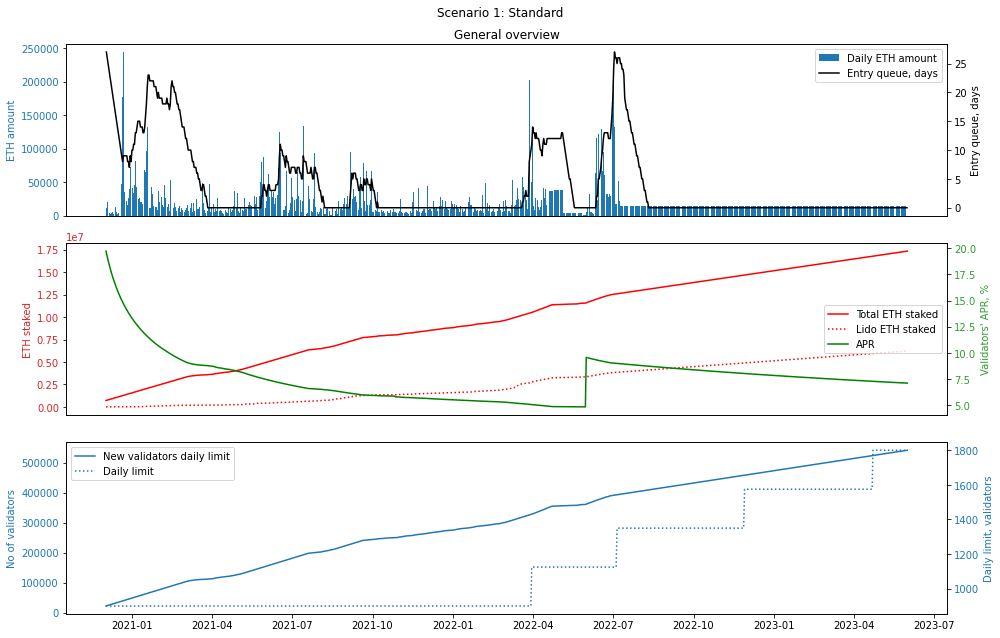

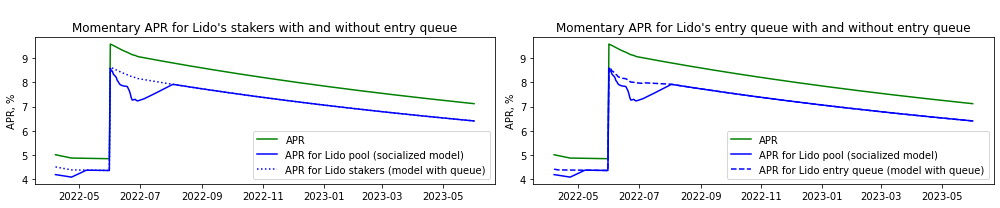

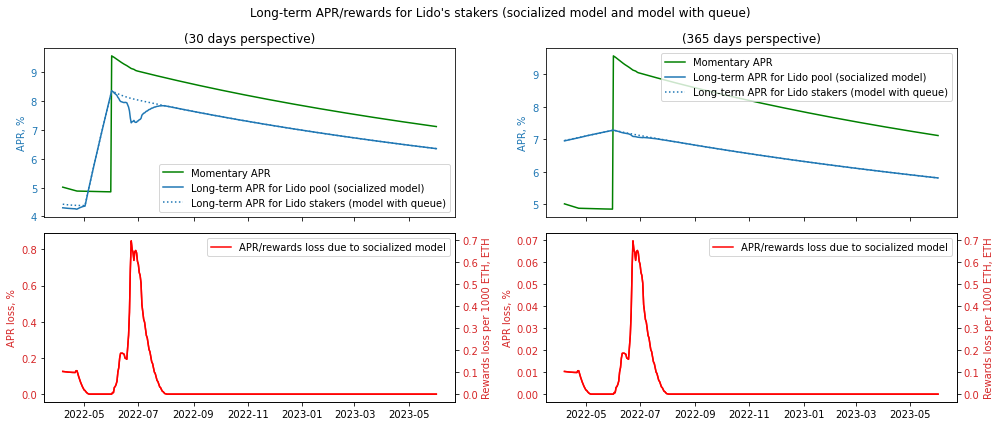

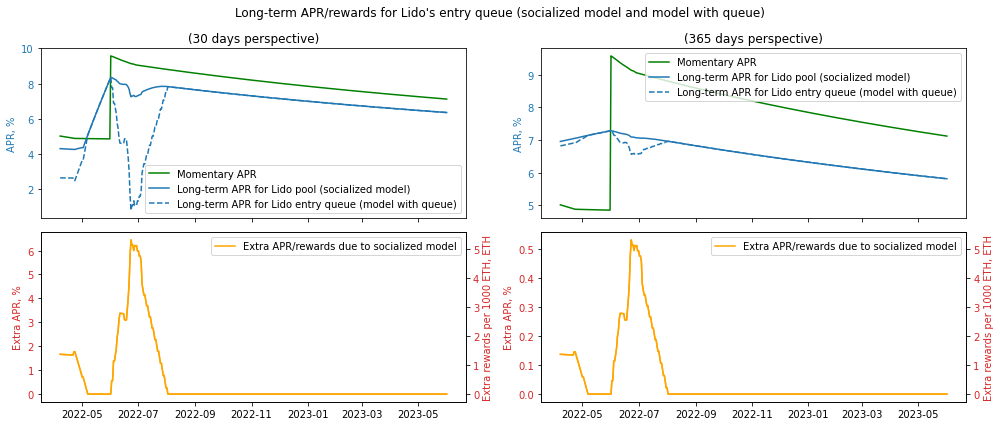

In [37]:
new_validators_per_epoch = 2
k = 0
lido_amount_share = 0.5
queue_before_merge_days = 14
queue_after_merge_days = 28
queue_before_merge_amount = 1_00_000
queue_after_merge_amount = 2_000_000

df = get_simulation(queue_before_merge_days, queue_before_merge_amount, queue_after_merge_days, queue_after_merge_amount, lido_amount_share, new_validators_per_epoch, k, model_queue)
APR_scenario_1 = df[df.index>=pd.Timestamp(GENESIS_DATE)].APR
actual_APR_scenario_1 = df[df.index>=pd.Timestamp(GENESIS_DATE)].APR_actual_staked_365
get_lido_charts(df, APR_periods, 'Scenario 1: Standard')
 

## Scenario 2: Harsh

,"Max APR loss for Lido stakers, percent points","Max APR loss for Lido stakers, %","Max rewards loss for Lido stakers per 1000 ETH, ETH"
Period,,,
30,2.509871,32.046043,2.062907
365,0.423863,6.218945,4.238630


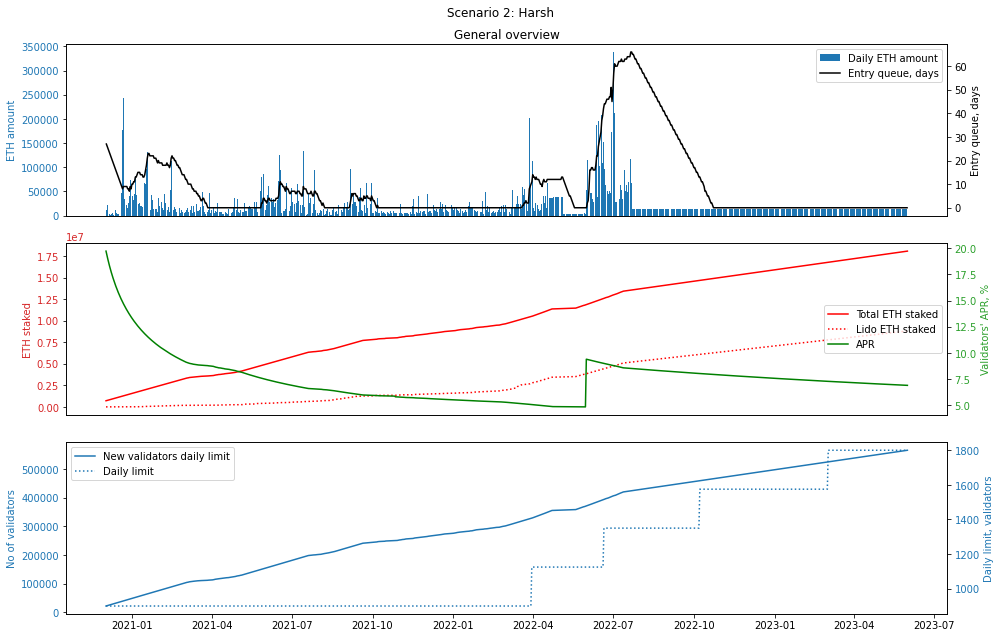

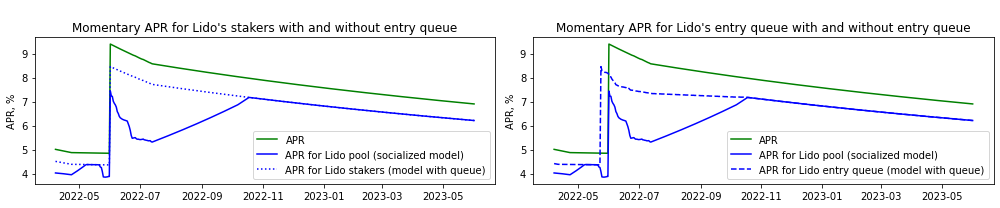

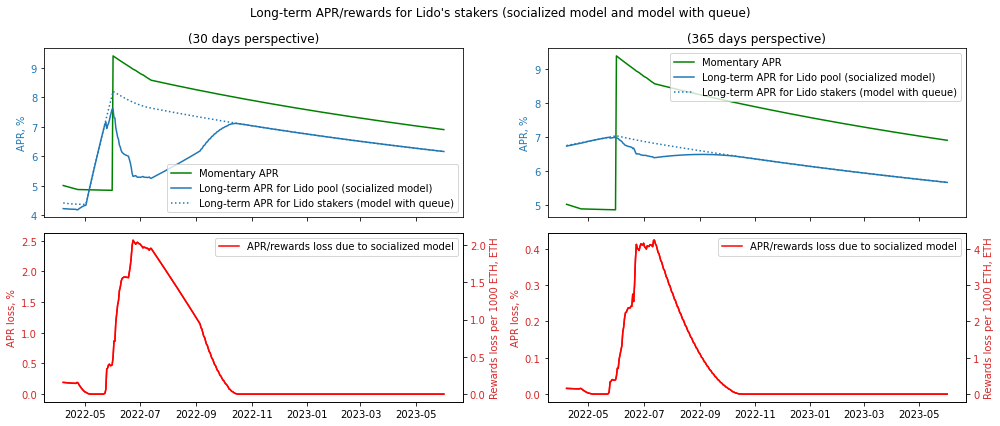

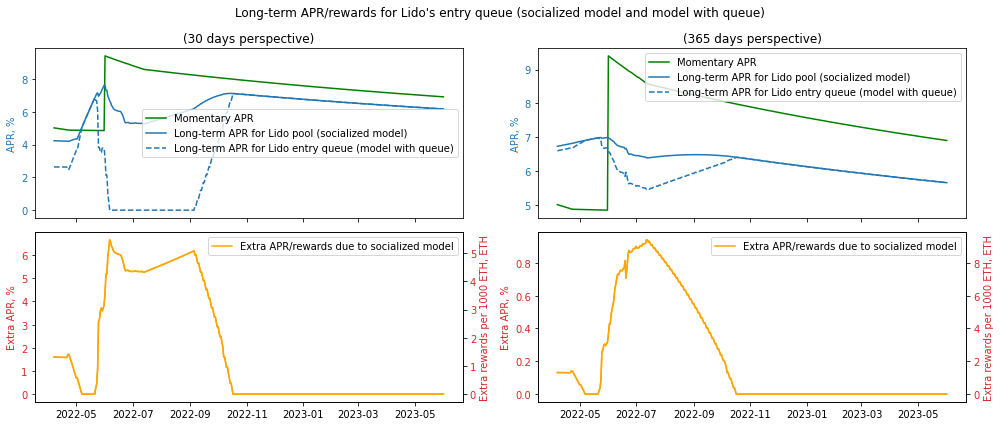

In [38]:
new_validators_per_epoch = 2
k = 0
lido_amount_share = 0.8
queue_before_merge_days = 14
queue_after_merge_days = 42
queue_before_merge_amount = 1_000_000
queue_after_merge_amount = 4_000_000

df = get_simulation(queue_before_merge_days, queue_before_merge_amount, queue_after_merge_days, queue_after_merge_amount, lido_amount_share, new_validators_per_epoch, k, model_queue)
APR_scenario_2 = df[df.index>=pd.Timestamp(GENESIS_DATE)].APR
actual_APR_scenario_2 = df[df.index>=pd.Timestamp(GENESIS_DATE)].APR_actual_staked_365
get_lido_charts(df, APR_periods, 'Scenario 2: Harsh')

## Scenario 3: "like Genesis"

,"Max APR loss for Lido stakers, percent points","Max APR loss for Lido stakers, %","Max rewards loss for Lido stakers per 1000 ETH, ETH"
Period,,,
30,0.209120,2.612881,0.17188
365,0.017188,0.242399,0.17188


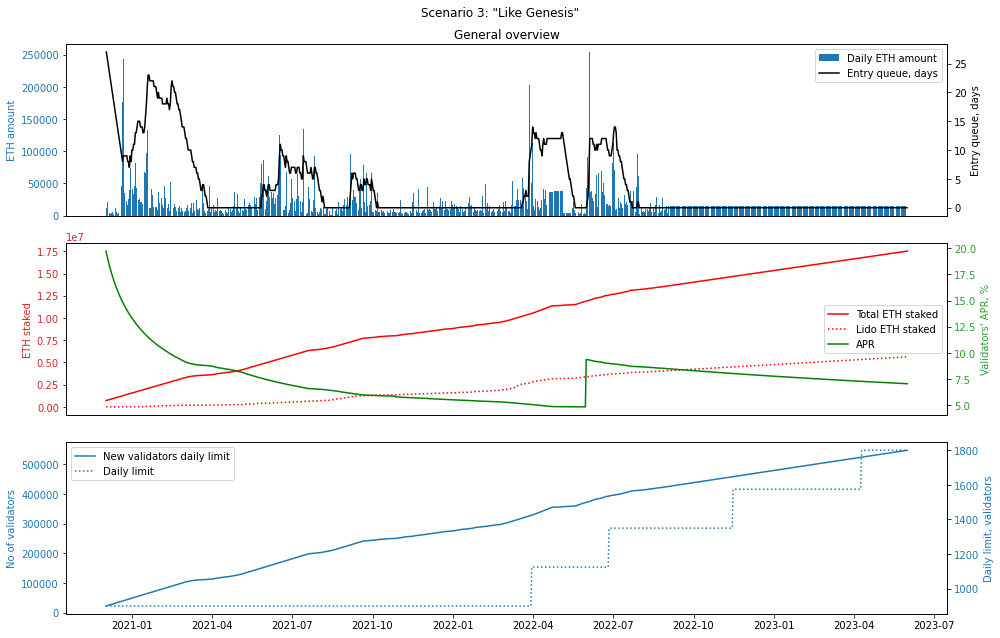

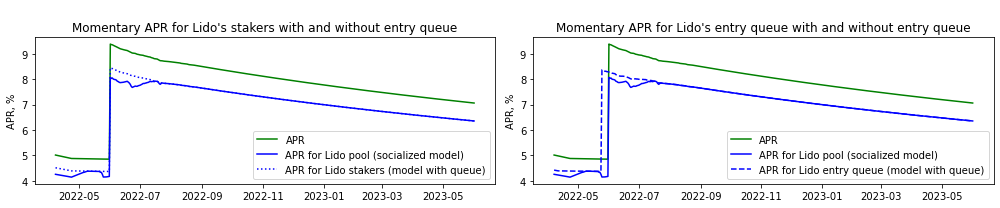

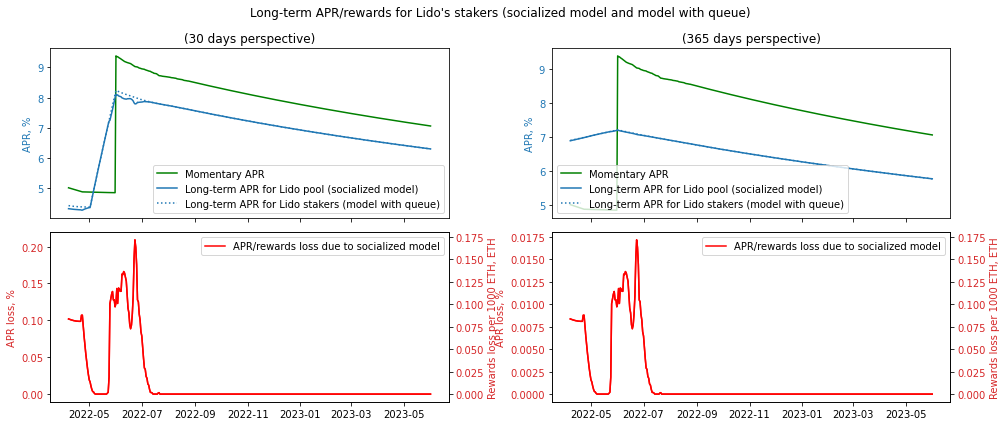

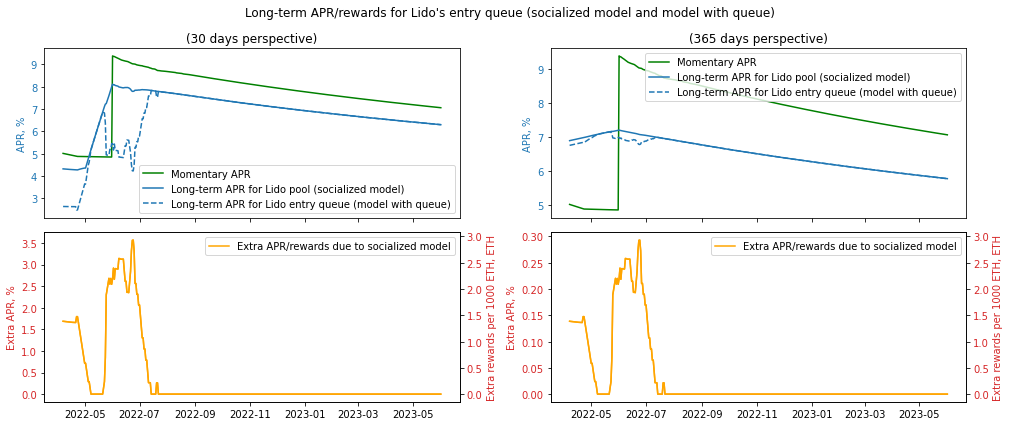

In [39]:
new_validators_per_epoch = 2
k = 0
lido_amount_share = 0.4
queue_before_merge_days = 28
queue_after_merge_days = 84
queue_before_merge_amount = 900_000
queue_after_merge_amount = 2_000_000

df = get_simulation(queue_before_merge_days, queue_before_merge_amount, queue_after_merge_days, queue_after_merge_amount, lido_amount_share, new_validators_per_epoch, k, model_queue)
APR_scenario_3 = df[df.index>=pd.Timestamp(GENESIS_DATE)].APR
actual_APR_scenario_3 = df[df.index>=pd.Timestamp(GENESIS_DATE)].APR_actual_staked_365
get_lido_charts(df, APR_periods, 'Scenario 3: "Like Genesis"')

# Appendix

## Chats for presentation and publication

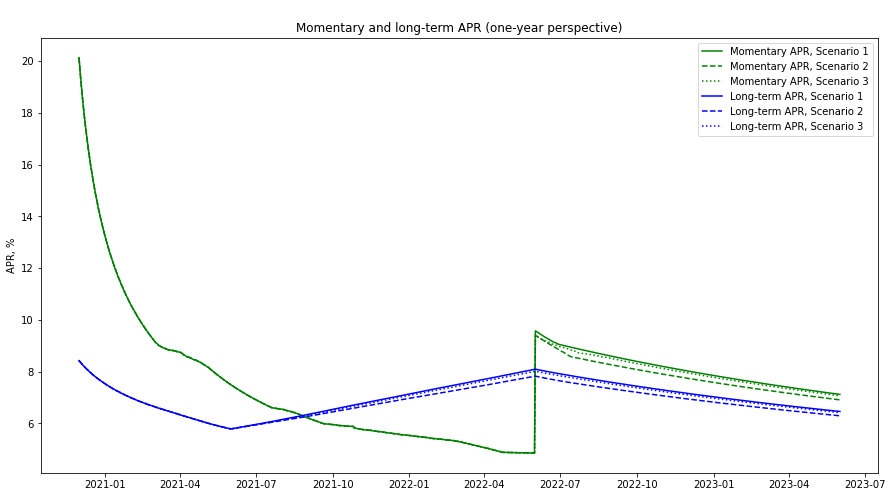

In [40]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(APR_scenario_1.index.values, APR_scenario_1, color = 'green', label='Momentary APR, Scenario 1')
ax.plot(APR_scenario_2.index.values, APR_scenario_2, color = 'green', label='Momentary APR, Scenario 2', linestyle="dashed")
ax.plot(APR_scenario_3.index.values, APR_scenario_3, color = 'green', label='Momentary APR, Scenario 3', linestyle="dotted")
ax.plot(actual_APR_scenario_1.index.values, actual_APR_scenario_1, color = 'blue', label='Long-term APR, Scenario 1')
ax.plot(actual_APR_scenario_2.index.values, actual_APR_scenario_2, color = 'blue', label='Long-term APR, Scenario 2', linestyle="dashed")
ax.plot(actual_APR_scenario_3.index.values, actual_APR_scenario_3, color = 'blue', label='Long-term APR, Scenario 3', linestyle="dotted")
ax.set_ylabel('APR, %')
ax.set_title(f"\nMomentary and long-term APR (one-year perspective)")
leg = ax.legend()

Text(0.5, 1.0, '\nStaking APR with MEV and priority fee')

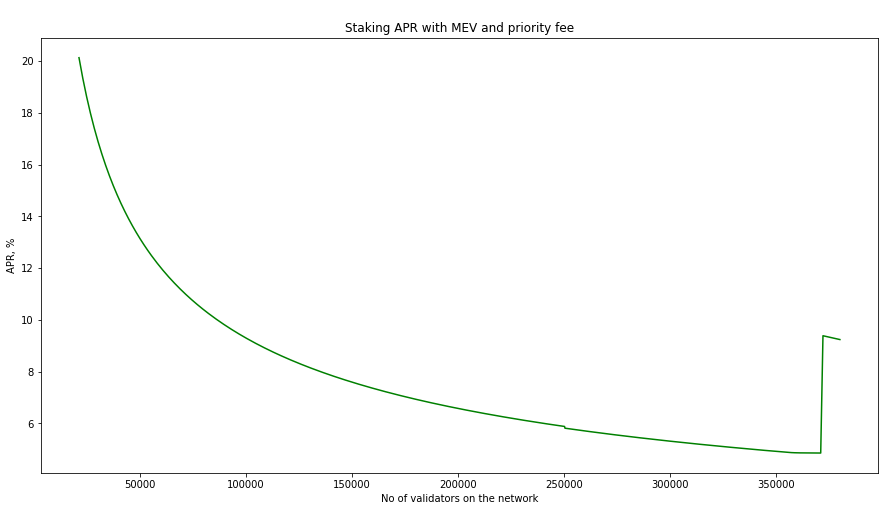

In [41]:
fig, ax = plt.subplots(figsize=(15, 8))

#ax.plot(df[(df.index>=pd.Timestamp(GENESIS_DATE)) & (df.index <= df_validatorscount_actual.index[-1])].validatorscount.values, df[(df.index>=pd.Timestamp(GENESIS_DATE)) & (df.index <= df_validatorscount_actual.index[-1])].APR, color = 'green')
ax.plot(df[(df.index>=pd.Timestamp(GENESIS_DATE)) & (df.validatorscount<=380000)].validatorscount.values, df[(df.index>=pd.Timestamp(GENESIS_DATE)) & (df.validatorscount<=380000) ].APR, color = 'green')

ax.set_ylabel('APR, %')
ax.set_xlabel('No of validators on the network')
ax.set_title("\nStaking APR with MEV and priority fee")

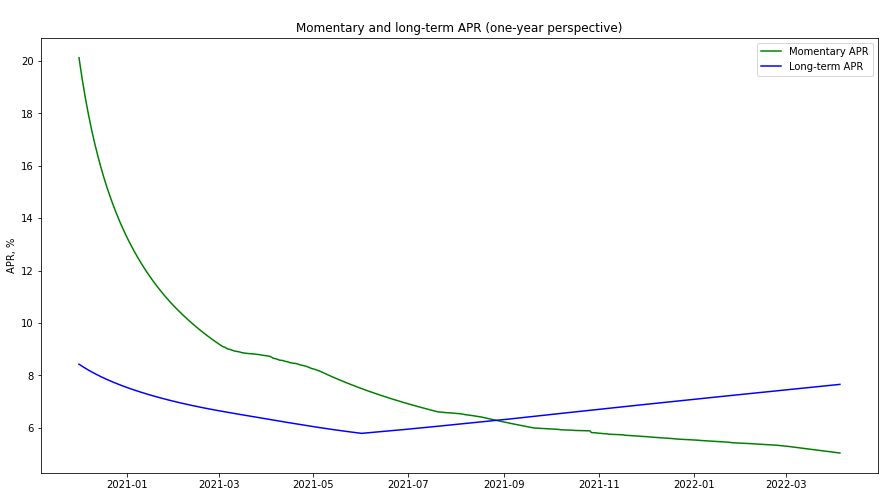

In [42]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(df[(df.index>=pd.Timestamp(GENESIS_DATE)) & (df.index <= df_validatorscount_actual.index[-1])].index.values, df[(df.index>=pd.Timestamp(GENESIS_DATE)) & (df.index <= df_validatorscount_actual.index[-1])].APR.values, color = 'green', label='Momentary APR')
ax.plot(df[(df.index>=pd.Timestamp(GENESIS_DATE)) & (df.index <= df_validatorscount_actual.index[-1])].index.values, df[(df.index>=pd.Timestamp(GENESIS_DATE)) & (df.index <= df_validatorscount_actual.index[-1])].APR_actual_staked_365.values, color = 'blue', label='Long-term APR')


ax.set_ylabel('APR, %')
ax.set_title(f"\nMomentary and long-term APR (one-year perspective)")
leg = ax.legend()

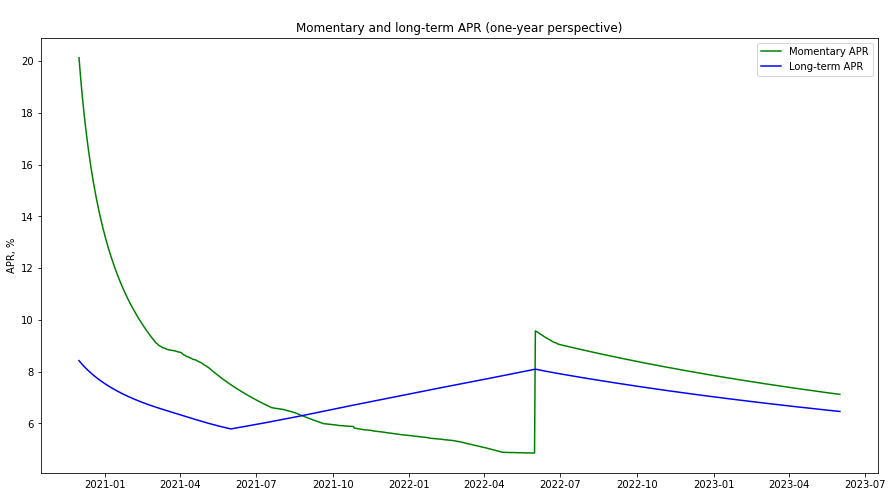

In [43]:
fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(APR_scenario_1.index.values, APR_scenario_1, color = 'green', label='Momentary APR')

ax.plot(actual_APR_scenario_1.index.values, actual_APR_scenario_1, color = 'blue', label='Long-term APR')

ax.set_ylabel('APR, %')
ax.set_title(f"\nMomentary and long-term APR (one-year perspective)")
leg = ax.legend()